<a href="https://colab.research.google.com/github/Deepak-Byte/FaceExpressionRecognizer/blob/main/Facialrecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Aug 13 15:53:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!wget https://dropbox.com/s/si11cws2pyho1bp/archive.zip

--2024-08-13 15:53:39--  https://dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving dropbox.com (dropbox.com)... 162.125.248.18, 2620:100:6040:18::a27d:f812
Connecting to dropbox.com (dropbox.com)|162.125.248.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip [following]
--2024-08-13 15:53:40--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap [following]
--2024-08-13 15:53:41--  https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response.

In [ ]:
!unzip -q "/content/archive.zip"

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
train_path = Path("/content/train")
test_path = Path("/content/test")

In [ ]:
train_image_path = list(train_path.glob("*/*"))
train_image_path = list(map(lambda x: str(x), train_image_path))

train_image_path[:10]

['/content/train/angry/Training_48043757.jpg',
 '/content/train/angry/Training_17825044.jpg',
 '/content/train/angry/Training_29054231.jpg',
 '/content/train/angry/Training_33368937.jpg',
 '/content/train/angry/Training_42046397.jpg',
 '/content/train/angry/Training_60157856.jpg',
 '/content/train/angry/Training_96565451.jpg',
 '/content/train/angry/Training_93122651.jpg',
 '/content/train/angry/Training_51261079.jpg',
 '/content/train/angry/Training_90326018.jpg']

In [ ]:
train_image_path[-2]

'/content/train/disgust/Training_8937293.jpg'

In [ ]:
#getting respective lable
def get_lable(image_path):
  return image_path.split("/")[-2]

train_image_lable = list(map(lambda x : get_lable(x), train_image_path))
train_image_lable[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_image_lable = le.fit_transform(train_image_lable)
train_image_lable[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
train_image_lable = tf.keras.utils.to_categorical(train_image_lable)
train_image_lable[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
for i, category in enumerate(le.classes_):
    print(f"Label {i}: {category}")


Label 0: angry
Label 1: disgust
Label 2: fear
Label 3: happy
Label 4: neutral
Label 5: sad
Label 6: surprise


In [ ]:
from sklearn.model_selection import train_test_split

train_path, val_path, train_label, val_label = train_test_split(train_image_path, train_image_lable, test_size=0.25)


In [ ]:
classtotal = train_label.sum(axis=0)
class_weight = classtotal.max()/classtotal

class_weight = {e: weight for e, weight in enumerate(class_weight)}
print(class_weight)

{0: 1.7987400530503979, 1: 15.909090909090908, 2: 1.7757774140752864, 3: 1.0, 4: 1.4614762931034482, 5: 1.5011068068622024, 6: 2.2909628378378377}


In [ ]:
# fudntion used for transformation
def load(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  return image, label

In [ ]:
# define image and batch size
IMAGE_SIZE = 96
BATCHE_SIZE = 32

#basic transformation
resize = tf.keras.Sequential([tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)])

#data augumentation
data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.05))
    ])

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def getdataset(path, label, train = True):
  image_path = tf.convert_to_tensor(path)
  label      = tf.convert_to_tensor(label)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_path)
  label_dataset = tf.data.Dataset.from_tensor_slices(label)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

  dataset = dataset.map(lambda image, label : load(image, label))
  dataset = dataset.map(lambda image, label : (resize(image), label), num_parallel_calls=AUTOTUNE)
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(BATCHE_SIZE)

  if train:
    dataset = dataset.map(lambda image, label : (data_augumentation(image), label), num_parallel_calls=AUTOTUNE)
  dataset = dataset.repeat()
  return dataset


In [ ]:
# creating train dataset and veriying
%time
train_dataset = getdataset(train_path, train_label)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
(32, 96, 96, 3)
(32, 7)


sad


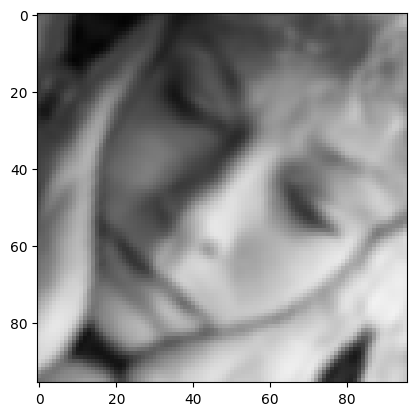

In [ ]:
#view sample training image
print(le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

In [ ]:
%time
val_dataset = getdataset(val_path, val_label, train = False)
image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs
(32, 96, 96, 3)
(32, 7)


In [ ]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model

input_layer = Input(shape=(96, 96, 3))
backbone = EfficientNetB2(include_top=False, weights=None, input_tensor=input_layer)
x = GlobalAveragePooling2D()(backbone.output)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(7, activation="softmax")(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


# backbone = EfficientNetB2(input_shape=(96, 96, 3), include_top=False, weights=None)

# model = tf.keras.Sequential([
#     backbone,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dense(7, activation="softmax")
# ])
# model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_5           │ (None, 96, 96, 3)      │              7 │ rescaling_5[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ normalization_5[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 7,949,824 (30.33 MB)

 Trainable params: 7,882,249 (30.07 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
#compiling your model by providing optemizer

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon= 1e-07 ),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# train model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_path)//BATCHE_SIZE,
    epochs = 12,
    validation_data = val_dataset,
    validation_steps = len(val_path)//BATCHE_SIZE,
    class_weight = class_weight
)

Epoch 1/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 177s 101ms/step - accuracy: 0.1457 - loss: 3.5552 - precision: 0.1387 - recall: 0.0036 - val_accuracy: 0.1992 - val_loss: 1.9248 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 126s 98ms/step - accuracy: 0.1987 - loss: 3.3552 - precision: 0.4213 - recall: 0.0038 - val_accuracy: 0.2261 - val_loss: 1.8754 - val_precision: 0.4000 - val_recall: 2.7988e-04
Epoch 3/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.2152 - loss: 3.2744 - precision: 0.5073 - recall: 0.0144 - val_accuracy: 0.1895 - val_loss: 1.8697 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.1775 - loss: 3.2447 - precision: 0.5759 - recall: 0.0265 - val_accuracy: 0.1990 - val_loss: 1.8383 - val_precision: 0.5972 - val_recall: 0.0353
Epoch 5/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 60s 89ms/step - accuracy: 0.2076 - loss: 3.2191 - precision: 0.5767 - recall: 0.0327 - va

In [ ]:
model.layers[0].trainable = False

In [ ]:
#define our call back
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.weights.h5',
                                                verbose = 1,
                                                save_best_only=True,
                                                save_weights_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_5           │ (None, 96, 96, 3)      │              7 │ rescaling_5[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ normalization_5[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 23,714,324 (90.46 MB)

 Trainable params: 7,882,249 (30.07 MB)

 Non-trainable params: 67,575 (263.97 KB)

 Optimizer params: 15,764,500 (60.14 MB)

In [ ]:
#train model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_path)//BATCHE_SIZE,
    epochs = 8,
    callbacks = [checkpoint, earlystop],
    validation_data = val_dataset,
    validation_steps = len(val_path)//BATCHE_SIZE,
    class_weight = class_weight)

Epoch 1/8
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3447 - loss: 2.8862 - precision: 0.6790 - recall: 0.1242
Epoch 1: val_loss improved from inf to 1.54510, saving model to best_model.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 63s 93ms/step - accuracy: 0.3448 - loss: 2.8862 - precision: 0.6790 - recall: 0.1242 - val_accuracy: 0.4016 - val_loss: 1.5451 - val_precision: 0.6329 - val_recall: 0.1989
Epoch 2/8
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3783 - loss: 2.7772 - precision: 0.6899 - recall: 0.1613
Epoch 2: val_loss improved from 1.54510 to 1.47142, saving model to best_model.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.3783 - loss: 2.7772 - precision: 0.6898 - recall: 0.1613 - val_accuracy: 0.4264 - val_loss: 1.4714 - val_precision: 0.7253 - val_recall: 0.1800
Epoch 3/8
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3874 - loss: 2.7209 - precision: 0.6923 - recall: 0.1672
Epoch 3: val_loss did not improve from 1.47142
672/67

In [ ]:
#model = tf.keras.models.load_model('best_model.h5')
model.save_weights('best_model.weights.h5')
model.load_weights('best_model.weights.h5')

In [ ]:
#create dataset object for testing
test_image_path = list(test_path.glob("*/*"))
test_image_path = list(map(lambda x: str(x), test_image_path))

test_lables = list(map(lambda x : get_lable(x), test_image_path))

test_lables = le.transform(test_lables)
test_lables = tf.keras.utils.to_categorical(test_lables)

test_image_path  = tf.convert_to_tensor(test_image_path, dtype=tf.string)
test_lables      = tf.convert_to_tensor(test_lables, dtype=tf.float32)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [96, 96], method = "bilinear")
  return image, label

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_path,test_lables)).map(decode_image).batch(BATCHE_SIZE)


In [ ]:
#verfy test dataset
#image , label = next(iter(test_dataset))
outputp = next(iter(test_dataset))

print(outputp)
#print(label.shape)

(<tf.Tensor: shape=(32, 96, 96, 3), dtype=float32, numpy=
array([[[[207.    , 207.    , 207.    ],
         [207.    , 207.    , 207.    ],
         [207.    , 207.    , 207.    ],
         ...,
         [ 51.5   ,  51.5   ,  51.5   ],
         [ 48.5   ,  48.5   ,  48.5   ],
         [ 47.    ,  47.    ,  47.    ]],

        [[206.5   , 206.5   , 206.5   ],
         [206.625 , 206.625 , 206.625 ],
         [206.875 , 206.875 , 206.875 ],
         ...,
         [ 51.1875,  51.1875,  51.1875],
         [ 49.5625,  49.5625,  49.5625],
         [ 48.75  ,  48.75  ,  48.75  ]],

        [[205.5   , 205.5   , 205.5   ],
         [205.875 , 205.875 , 205.875 ],
         [206.625 , 206.625 , 206.625 ],
         ...,
         [ 50.5625,  50.5625,  50.5625],
         [ 51.6875,  51.6875,  51.6875],
         [ 52.25  ,  52.25  ,  52.25  ]],

        ...,

        [[152.75  , 152.75  , 152.75  ],
         [148.9375, 148.9375, 148.9375],
         [141.3125, 141.3125, 141.3125],
         ...,
     

fear


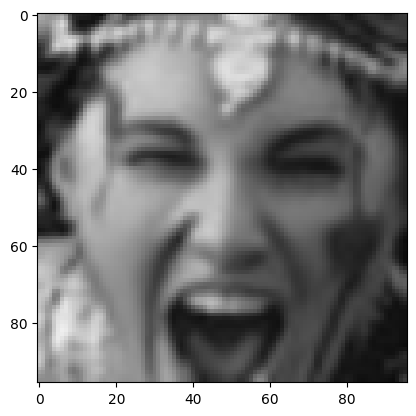

In [ ]:
#view sample validation image
print(le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

In [ ]:
print(type(test_dataset))
print(type(train_dataset))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
<class 'tensorflow.python.data.ops.repeat_op._RepeatDataset'>


In [ ]:
#evaluating mdoel
loss, acc, pre, recall = model.evaluate(test_dataset)
print("loss: ", loss)
print("accuracy: ", acc)
print("precision: ", pre)
print("recall: ", recall)

225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5906 - loss: 1.2302 - precision: 0.8179 - recall: 0.4041
loss:  1.4967044591903687
accuracy:  0.449986070394516
precision:  0.6666666865348816
recall:  0.24268598854541779


In [ ]:
#saving model
model.save("FacialExpressionMmodel.h5")

In [ ]:
#save label encoder
import pickle

def save_obj(obj, name ):
  pickle_obj = open(f"{name}.pkl", "wb")
  pickle.dump(obj, pickle_obj)
  pickle_obj.close()

In [ ]:
save_obj(le, "label_encoder")